# Linear Regression with normal equation & SVD

Basic formula for $n$ features with $\theta_i$ model parameters:

\begin{equation}
\hat{y} = \theta_0 + \theta_1 x_1 + \theta_2 x_2 + \cdots + \theta_n x_n = \vec{\theta} \cdot \vec{x}
\end{equation}

Actually, we should write our data as a matrix, since there are $m$ data points (targets), each with $n$ features:

\begin{equation}
\vec{\hat{y}} = \mathbf{X}\vec{\theta}
\end{equation}

Where $\vec{y}$ is a column vector with $m$ rows, $\mathbf{X}$ is a $m \times n$ matrix of data points, and $\vec{\theta}$ is a $n$-row column matrix of parameters.

We can write the mean squared error as:

\begin{equation}
\text{MSE} = \frac{1}{m} \sum_{i=1}^{m} \left(\vec{\theta}^T\vec{x}^{(i)} - y^{(i)} \right)^2 = \|\mathbf{X}\vec{\theta} - \vec{y}\|^2
\end{equation}

where $\vec{y}$ are the true/target values.

This can be solved exactly using the **normal equation**:

\begin{equation}
\vec{\hat{\theta}} = (\mathbf{X}^T\mathbf{X})^{-1} \mathbf{X}^T \vec{y}
\end{equation}

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline

mpl.rcParams['font.size'] = 14
mpl.rcParams['figure.figsize'] = (10, 8)


In [13]:
# generate random data
X = 2 * np.random.rand(100, 1)
y = 4 + 3*X + np.random.randn(100, 1)

In [5]:
# add bias term (x_0 = 1)
X_b = np.c_[np.ones((100, 1)), X]
# do normal equation solution to get parameters
theta_best = np.linalg.inv(X_b.T @ X_b) @ X_b.T @ y

In [6]:
theta_best

array([[4.31157576],
       [2.63170094]])

This is very close to our true values of [4, 3]! We can draw a line of best fit using these predictions

[4.31157576 9.57497764]


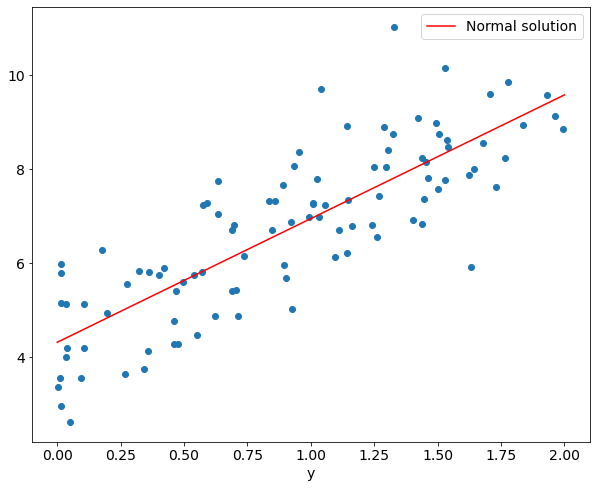

In [7]:
plt.scatter(X, y)
plt.xlabel('x1');
plt.xlabel('y');

X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), np.array([[0], [2]])]
y_predict = X_new_b @ theta_best
print(y_predict.flatten())
plt.plot(X_new, y_predict, 'r-', label='Normal solution')
plt.legend();

In [2]:
# We can also do this using scikit-learn linear regression
from sklearn.linear_model import LinearRegression

In [9]:
lin_reg = LinearRegression()
lin_reg.fit(X, y) # nb don't need to pad with 1s ourself

LinearRegression()

In [10]:
lin_reg.intercept_, lin_reg.coef_

(array([4.31157576]), array([[2.63170094]]))

In [11]:
lin_reg.predict(X_new)

array([[4.31157576],
       [9.57497764]])

NB it does least squares internally from `scipy.linalg.lstsq()`. This solves for $\vec{\theta}$ using the pseudoinverse: $\vec{\theta} = \mathbf{X}^{+} \vec{y}$, where $\mathbf{X}^+$ is the pseudoinverse, calculated using **singular value decomposition (SVD)**.

SVD decomposes $\mathbf{X}$ into $\mathbf{U} \mathbf{\Sigma} \mathbf{V}^T$.

We can then calculate the pseudoinverse as $\mathbf{X}^+ = \mathbf{V} \mathbf{\Sigma}^+ \mathbf{U}^T$.

$\mathbf{\Sigma}^+$ is calculated from $\mathbf{\Sigma}$ by setting very small values less than a threshold to 0, and then replacing all leftover values by their inverse. This makes it very efficient. It also allows for a non-invertible matrix to be inverted, e.g. if singular, or $m<n$, or when features are redundant/degenerate, which may not be possible in the normal equation.


Complexity:

- **Normal equation**: requires computing inverse of $\mathbf{X}^T \mathbf{X}$, which is a $(n+1)\times(n+1)$ matrix ($n$ = # of features). Scales a $\mathcal{O} (n^{2.4 - 3})$, depending on the implementation, i.e. doubling # of features increases time by $\times \sim 5.3 - 8$

- **SVD**: scales as $\mathcal{O}(n^2)$, i.e. doubling $n$ increases time by $\times 4$

Both are slow when $n$ v.large (e.g 1E5).

Both are **linear** w.r.t number of samples, $m$, so happy to handle large samples (so long as fits memory). (\mathbf{X} is $m \times n$, so doesn't care about $m$ so much)

# Gradient Descent

**Gradient descent**: _generic_ optimisation algorithm to find optimum solution to a problem, updating parameters in order to minimise some cost function, by taking "steps" towards the solution, based on the local gradient at a given point in parameter space.

- Start with **random initialisation** of parameters $\vec{\theta}$

- Measure local gradient of cost function wrt $\vec{\theta}$

- Take a step using the gradient

- Repeat until **convergence**

**Learning rate**: hyperparameter controlling how big a "step" to update $\vec{\theta}$ each time.

- Too small: can take a long time to converge to minimum; can also get stuck in local minimum and not global minimum

- Too big: can jump out of minimum, or even enlarge cost function, causing a divergence

MSE for Linear regression is a **convex function**: the line segment joining any 2 points on curve is always above the curve itself - implies **no local minima**, just one global minimum.

It also has a continuous gradient function.

Convex function + continuous gradient = GD guaranteed to approach arbitrarily close to global minimum (provided enough time and small enough learning rate).


**Feature scaling**: better to standardise scale of features prior to GD - can take much longer to converge otherwise, since it can be otherwise led astray by an artificially larger gradient.


How to calculate GD on a dataset?:

- **Batch GD**: entire dataset each time - can be slow when dataset large, can't do out-of-core
- **Stochastic GD**: random entry from dataset each time - fast but erratic, can be hard to converge at minimum
- **Mini-batch GD**: use random smaller set of full training data each time (a _mini-batch_) = performance boost over stochastic GD, less erratic. Can handle out-of-core, and large $m$

## Batch Gradient Descent

Requires partial derivatives:

\begin{equation}
\nabla_{\vec{\theta}} \text{MSE} =  \frac{2}{m}\mathbf{X}^T(\mathbf{X} \vec{\theta} - \vec{y})
\end{equation}

Uses entire dataset ("batch"); can be slow on large sets.
Scales well with number of features.

Can update params: $\vec{\theta} \to \vec{\theta} - \eta \nabla_{\vec{\theta}}\text{MSE}$, where $\eta$ is the learning rate. Optimise using e.g. GridSearch

Can also stop GD when gradient becomes tiny, i.e. norm $< \epsilon$ (the tolerance).

Rate of converge inversely proportional to tolerance

NB terminology not clear - in some places "batch" is subset of full training dataset?

## Stochastic Gradient Descent

Batch GD requires whole dataset

Stochastic GD uses a random instance in the training set - only need to calculate gradient for that one instance.

Good: faster, can use large training sets out-of-core; erraticness good to help jump out of local minima

Bad: stochastic, so more erratic; can be hard to converge

To help convergence: decreasing learning rate with # steps taken - **simulated annealing** - determined by **learning schedule**.

**Epoch** each time we get through all $m$ training samples in the dataset. May require multiple epochs.

**Randomness** when picking samples required - otherwise might optimise for one type of data, then another - hard to converge.

Use `sklearn.linear_model.SGDRegressor`

## Mini-batch Gradient Descent

Compute gradients on small random subsets of the training dataset = "mini-batch"

Good: performance boost over stochastic GD from optimised matrix operations on GPUs; less erratic than SGD

Bad: still needs a learning schedule

NB Mini-batch GD with batch size = 1 is just SGD!

How to do in sklearn?? `SGDRegressor` is just for 1 sample in a batch

# Polynomial regression

Higher order terms than linear regression:

\begin{equation}
\hat{y} = \theta_0 + \theta_1 x + \theta_2 x^2 + \cdots + \theta_n x^n
\end{equation}

Essentially a linear regression with features $x$, $x^2$, ..., $x^n$

In [14]:
# dummy dataset with quadratic dependence + noise
m = 100
X = 6* np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

In [3]:
# generate polynomial features from our data
from sklearn.preprocessing import PolynomialFeatures

In [129]:
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)

In [130]:
# Can now do linear regression on polynomial features:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)

LinearRegression()

In [131]:
lin_reg.intercept_, lin_reg.coef_

(array([2.13990612]), array([[0.96436775, 0.47028299]]))

So pretty close to our intercept of 2, and coefficients 1, 0.5

In [132]:
X_line = np.arange(-3, 3.1, 0.1).reshape(-1, 1) # only order-1 terms
# need the poly_features.transform to generate the higher order terms, to then pass into linear regression
y_line = lin_reg.predict(poly_features.transform(X_line)) 

(-0.5, 12.0)

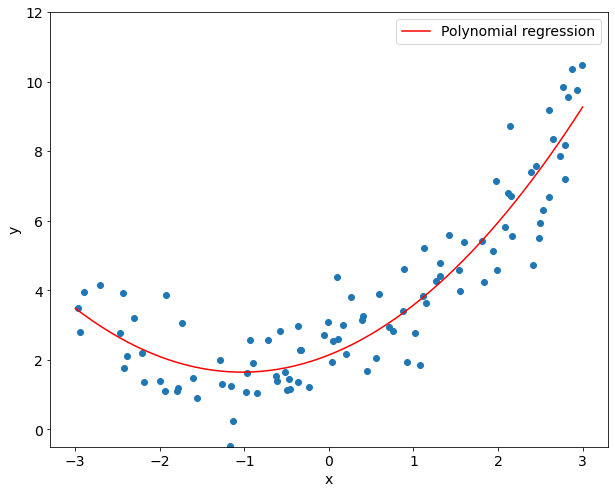

In [133]:
plt.scatter(X, y)
plt.plot(X_line, y_line, 'r-', label='Polynomial regression')
plt.xlabel('x')
plt.ylabel('y')
plt.legend();
plt.ylim(-0.5, 12)

NB `Polynomial Features` will also generate all cross-terms as well: e.g. if you have features a, b, it will generate for `degree=3`: $a^3$, $b^3$, $ab^2$, $a^2b$, $ab$

Watch out for large number of features - creates $(n+d)! / d!n!$ extra features for degree $d$ with $n$ original features

# Learning curves

How to tell if overfitting when fitting polynomials?

Already used cross-validation to test when training models.

Can also use **learning curves**: performance of the training & validation sets as a function of the training iteration / set size.


In [4]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [135]:
def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))
    plt.plot(np.sqrt(train_errors), 'r-+', linewidth=2, label='train')
    plt.plot(np.sqrt(val_errors), 'b-', linewidth=2, label='val')
    plt.legend()
    plt.xlabel('Training set size')
    plt.ylabel('RMSE')
    plt.ylim(0, 3);

## Underfitting (linear regression on a quadratic curve)

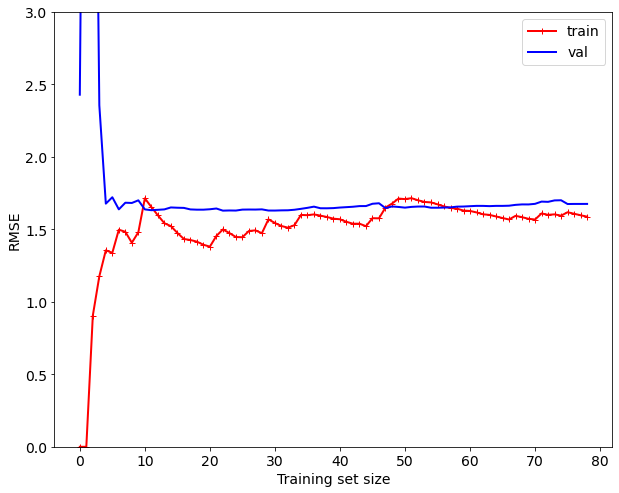

In [136]:
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)

In [5]:
from textwrap import wrap, fill

In [223]:
def lin_reg_str(lin_reg):
    coefs = lin_reg.coef_[0]
    intercept = "%.2g" % lin_reg.intercept_[0]
    orders = ['%.2g$x^{%d}$' % (coefs[i-1], i) for i in range(1, len(coefs)+1)]
    # use textwrap to wrap legend text
    return fill(' + '.join([intercept, *orders]), 50)

(-5.0, 15.0)

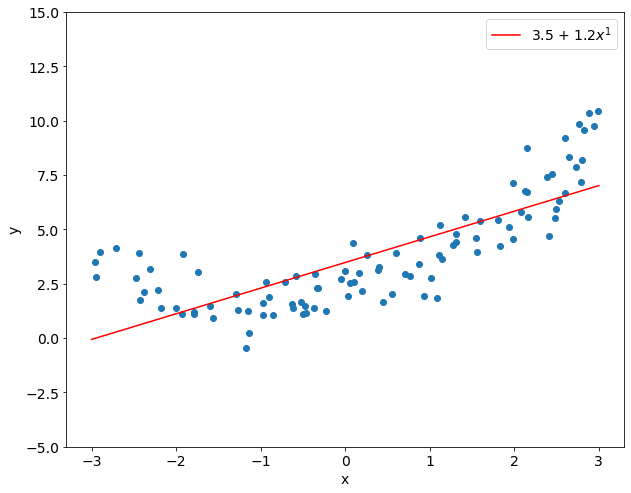

In [205]:
plt.scatter(X, y)
y_line = lin_reg.predict(X_line)
lin_str = lin_reg_str(lin_reg)
plt.plot(X_line, y_line, 'r-', label=lin_str)
plt.xlabel('x')
plt.ylabel('y')
plt.legend();
plt.ylim(-5, 15)

Once the training set hits ~10-20 elements, its performance plateaus, so adding more data doesn't help. (We know we have the wrong model, so it can only do so well before it becomes limited)

The validation set ends up plateauing as well, at a similar value. For small numbers, the validation set error is huge, while the training set error is ~0 (it can afford to fit ~exactly to the training set, and can't generalise at all)

## Overfitting (10th order polynomial on quadratic curve)

In [6]:
from sklearn.pipeline import Pipeline

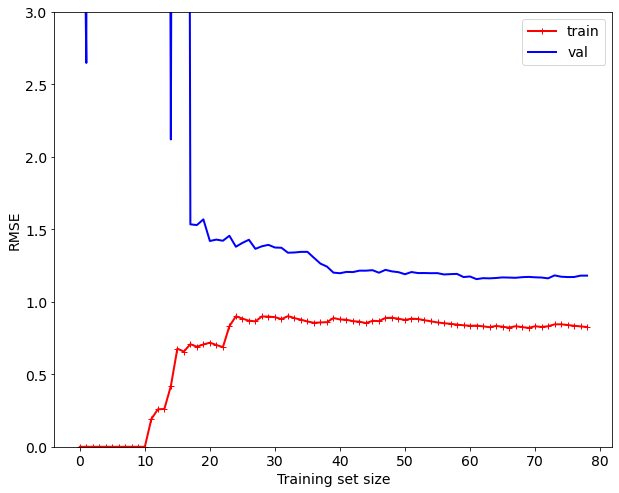

In [206]:
polynomial_regression = Pipeline([
    ('poly_features', PolynomialFeatures(degree=10, include_bias=False)),
    ('lin_reg', LinearRegression()),
])

plot_learning_curves(polynomial_regression, X, y)

(-5.0, 15.0)

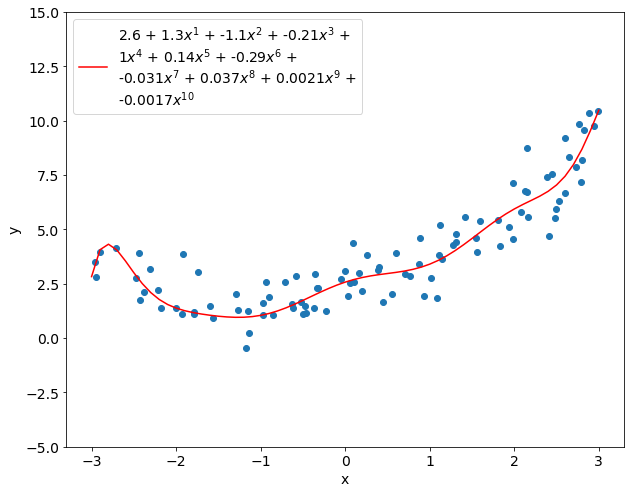

In [225]:
plt.scatter(X, y)
y_line = polynomial_regression.predict(X_line)
poly_str = lin_reg_str(polynomial_regression.named_steps['lin_reg'])
plt.plot(X_line, y_line, 'r-', label=poly_str)
plt.xlabel('x')
plt.ylabel('y')
plt.legend();
plt.ylim(-5, 15)

Now, the error is much smaller than in the underfitting case.

There is also a big gap between curves - this indicates that the model has "learnt" the training set well, but generalises poorly to the validation set.

One way to improve this is to increase the training set size until the validation set error becomes the same as the training set (i.e. the model has learnt enough to generalise)

## The correct model

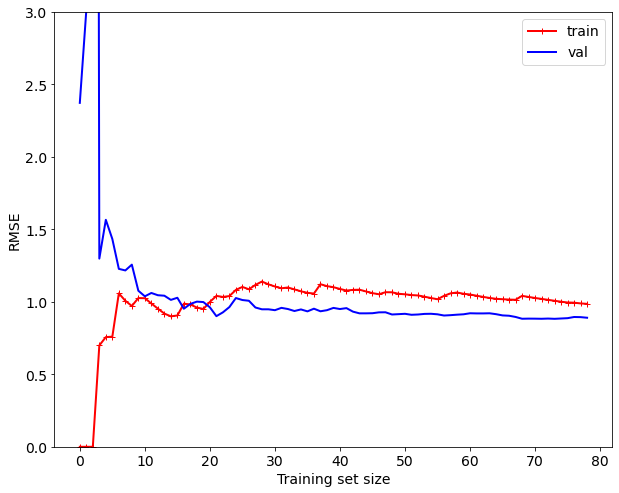

In [184]:
quadtratic_regression = Pipeline([
    ('poly_features', PolynomialFeatures(degree=2, include_bias=False)),
    ('lin_reg', LinearRegression()),
])

plot_learning_curves(quadtratic_regression, X, y)

Now we can see that the training and validation errors both plateau at similar values, but with an overall smaller error than in the linear (underfitting) case.

For comparison, here's a cubic model:

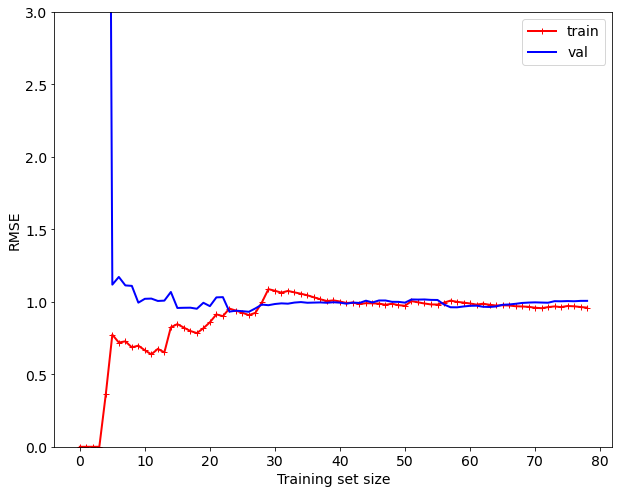

In [210]:
cubic_regression = Pipeline([
    ('poly_features', PolynomialFeatures(degree=3, include_bias=False)),
    ('lin_reg', LinearRegression()),
])

plot_learning_curves(cubic_regression, X, y)

(-5.0, 15.0)

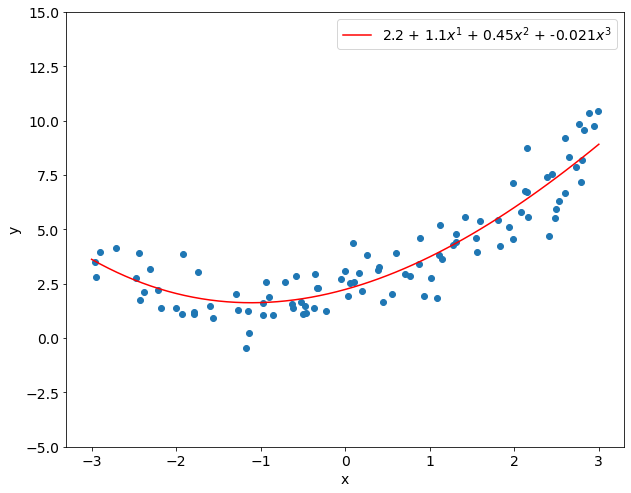

In [224]:
plt.scatter(X, y)
y_line = cubic_regression.predict(X_line)
poly_str = lin_reg_str(cubic_regression.named_steps['lin_reg'])
plt.plot(X_line, y_line, 'r-', label=poly_str)
plt.xlabel('x')
plt.ylabel('y')
plt.legend();
plt.ylim(-5, 15)

We note here that the cubic model actually doesn't do too badly! Its learning curves are v.similar to the quadratic case. However, looking at the coefficients, it is apparent that it is not really using the cubic term, and the quadratic terms are very similar to the quadratic model - we have a redundant model parameter that can be pruned away.

# Bias - Variance trade-off

**Bias**

- Due to wrong assumptions: e.g. that the data is linear when it is actually quadratic.

- High bias leads to **underfitting** training data (large RMSEs for both training & validation)

**Variance**:

- Due to model's sensitivity to small variations in training data

- E.g. in high-order polynomial, can have high variance, get **overfitting** of training data

- Small RMSE for training data, large for validation

**Irreducible error**:

- Due to inherent noise in data - required cleaning up input data

Increasing a model's complexity will increase its variance, whilst reducing its bias.
Similarly, decreasing its complexity will reduce variance, but increase its bias.

Can't magically reduce both.

# Regularization

Regularization: reduce overfitting by constraining degrees of freedom (e.g. removing higher order polynomial terms)

3 methods:

- **Ridge regression**: $\ell_2$ regularization (Tikhonov reg.)
- **Lasso regression**: $\ell_1$ regularization
- **Elastic Net**: combined $\ell_1 + \ell_2$ regularization

**Important**: must standard scale features first, since these do depend on relative scale of features.

Lasso and Elastic Net can remove redundant features, but Ridge can't.

Can also do **early stopping** as a form of regularization

## Ridge Regression

Add in regularization term using $\ell_2$ norm to cost function **only during training**:

\begin{equation}
\alpha \sum_{i=1}^n\theta_i^2 = \alpha \|\vec{w} \|_2
\end{equation}

This forces the model to keep the parameters small. Hyperparameter $\alpha$ control regularization strength.

Note that we define $\vec{w}$ as $\theta_{1...n}$, i.e. removing bias term.

Total cost function for training is:

\begin{equation}
J(\vec{\theta}) = \text{MSE}(\vec{\theta}) + \alpha \|\vec{w}\|_2
\end{equation}

NB cost function for training can be different to measuring performance on test data - $J$ should have optimisation-friendly derivatives, while the performance measure should reflect the final objective

e.g. classifiers trained using **log loss** since it's continuous & differentiable, but final performance evaluated using precision/recall

Ridge regression solution can either be calculated analytically, or by GD.

Closed-form solution:

\begin{equation}
\hat{\vec{\theta}} = (\mathbf{X}^T\mathbf{X} + \alpha \mathbf{A})^{-1} \mathbf{X}^T \vec{y}
\end{equation}

where $\mathbf{A}$ is $\mathbb{1}_{n+1}$ but with $\mathbf{A}_{00} = 0$ (corresponding to the bias term).

Do ridge regression with closed-form solution:

In [7]:
from sklearn.linear_model import Ridge

In [293]:
ridge_reg = Ridge(alpha=1, solver='cholesky')
# can also use 'sag' solver to use Stochastic Average GD,
# see https://www.cs.ubc.ca/~schmidtm/Documents/2014_Google_SAG.pdf
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[4.78311124]])

Do with SGD:

In [8]:
from sklearn.linear_model import SGDRegressor

In [292]:
sgd_reg = SGDRegressor(penalty='l2')
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([4.76026999])

## Lasso Regression

Lasso = Least Absolute Shrinkage and Selection Operator regression

Uses $\ell_1$ norm instead in cost function:


\begin{equation}
J(\vec{\theta}) = \text{MSE}(\vec{\theta}) + \alpha \|\vec{w}\|_1
\end{equation}

One difference wrt Ridge is that Lasso **can set weights of least important features to 0** - performs feature selection, output a **sparse model**.

This is because the gradient vector of the $\ell_1$ penalty term will direct the parameter vector towards an axis first if that parameter is small, and then move along it towards the origin; whereas for $\ell_2$ the gradient vector points towards the origin, and thus will reduce multiple parameters, but not setting the smallest to 0.

We can show contours of the pure regularization terms in a 2D parameter space, to show how the gradient influences the GD steps: we start at teh red dot, and the yellow arrows show the gradient from the $\ell_i$ norm

(In reality, when combined with the MSE, this will muddy the contours, but the general idea remains the same - the final set of parameters will lie on the line represented by yellow arrows)

**But** Lasso may behave erratically when number of features > number of training samples, or when severe correlation among features

In [9]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def colorbar(mappable):
    # handy function to stop colorbar squishing aspect ratio
    # taken from https://joseph-long.com/writing/colorbars/
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = fig.colorbar(mappable, cax=cax)
    plt.sca(last_axes)
    return cbar

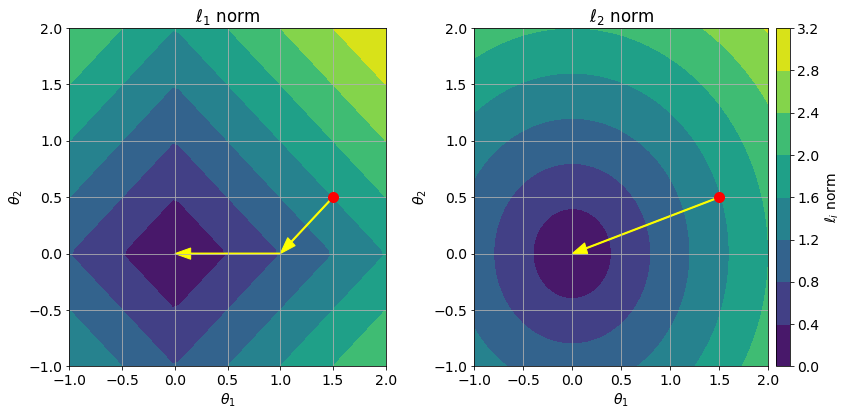

In [289]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
x_g = np.linspace(-1, 2, 50)
y_g = np.linspace(-1, 2, 50)
X_g, Y_g = np.meshgrid(x, y)  # builds two-dimensional grids from one-dimensional arrays
# print(X.shape)
# print(X)

Z_1 = np.abs(X_g)+np.abs(Y_g) # calc l_1 norm
ax[0].contourf(X_g, Y_g, Z_1)
ax[0].set_xlabel(r'$\theta_1$')
ax[0].set_ylabel(r'$\theta_2$')
ax[0].set_title(r'$\ell_1$' + ' norm')
ax[0].grid()
ax[0].plot([1.5], [0.5], 'ro', markersize=10)
ax[0].arrow(1.5, 0.5, dx=-0.5, dy=-0.5, 
            width=0.01, head_width=0.1, color='yellow', 
            length_includes_head=True)
ax[0].arrow(1, 0, dx=-1, dy=-0, 
            width=0.01, head_width=0.1, color='yellow', 
            length_includes_head=True)

Z_2 = np.hypot(X_g, Y_g) # calc l_2 norm
cset2 = ax[1].contourf(X_g, Y_g, Z_2)
ax[1].set_xlabel(r'$\theta_1$')
ax[1].set_ylabel(r'$\theta_2$')
ax[1].set_title(r'$\ell_2$' + ' norm')
ax[1].grid()
ax[1].plot([1.5], [0.5], 'ro', markersize=10)
ax[1].arrow(1.5, 0.5, dx=-1.5, dy=-0.5, 
            width=0.01, head_width=0.1, color='yellow', 
            length_includes_head=True)

cbar = colorbar(cset2);
cbar.set_label(r'$\ell_i$ norm')
plt.tight_layout()

In [10]:
from sklearn.linear_model import Lasso

In [291]:
lasso_reg = Lasso(alpha=0.1) # or use SGDRegressor(penalty='l1')
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([4.73311569])

## Elastic Net

Mixture of Lasso and Ridge regression, extra hyperparemeter $r \in [0, 1]$ to control mixture:

\begin{equation}
J(\vec{\theta}) = \text{MSE} + r \alpha \|\vec{w}\|_1 + \frac{1-r}{2}\alpha \|\vec{w}\|_2
\end{equation}

Prefer elastic net over pure Lasso to avoid erratic behaviour if # features > # samples, or strongly correlated features

In [11]:
from sklearn.linear_model import ElasticNet

In [15]:
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([4.6382302])

## Early Stopping

Stop training once validation error hits minimum - if you do more training, may overfit to training sample, and validation error will then increase again.

With GD, can be noisy - hard to tell if minimum. Instead stop once validation error been > minimum for N interations, then roll back model to minimum.

# Logisitic Regression

Form of regression useful for classification - for estimating probabilities.

Basically applies logistic function to linear regression model.

\begin{equation}
\hat{p} = \sigma(\vec{\theta}\cdot\vec{x})
\end{equation}

where $\sigma(t)$ is the sigmoid function:

\begin{equation}
\sigma(t) = \frac{1}{1 + \exp(-t)}
\end{equation}

which plateaus in $\lim_{t \to \inf} \sigma(t) = 1$, and in $\lim_{t \to -\inf} \sigma(t) = 0$. This makes it useful for probabilities.

Once we have a probability, we can make a classification, based on $\hat{p} > 0.5$.

NB $t$ called _logit_: logit(p) = $\log(p / (1-p))$ is inverse of logistic function. It is also called log-odds, since log of ratio between probability of +ve class and probability of -ve class.

In [12]:
from scipy.special import expit

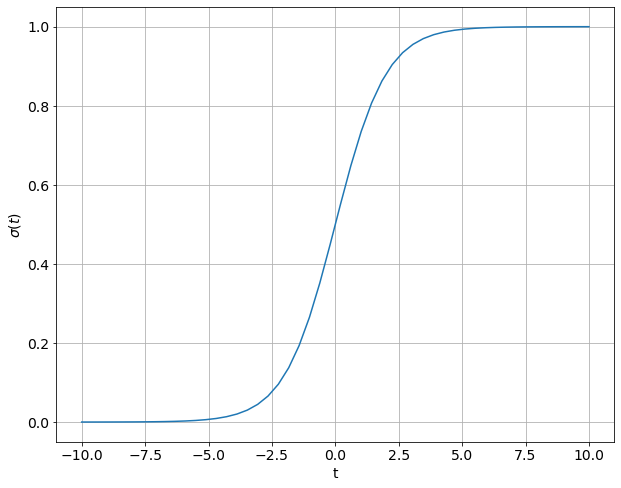

In [304]:
x_sig = np.linspace(-10, 10, 50)
# y_sig = expit(x_sig)
y_sig = 1. / (1 + np.exp(-x_sig))
plt.plot(x_sig, y_sig)
plt.xlabel('t')
plt.ylabel(r'$\sigma(t)$')
plt.grid();

## Training & Cost Function

The cost function should be large when the class is incorrect:

\begin{equation}
-\log(\hat{p}) \text{ if y = 1}\\
-\log(1-\hat{p}) \text{ if y = 0}
\end{equation}

$\log(t)$ becomes large as $t \to 0$, so the cost will be large if a positive case is classified as a negative ($\hat{p} \to 0$), and similarly a negative case classified as a positive ($\hat{p} \to 1$). These costs are visualised below:

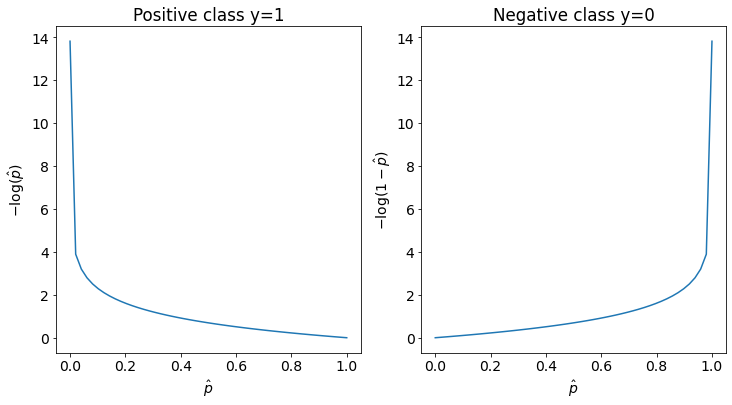

In [21]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 6))
x_log = np.linspace(1E-6, 1-1E-6, 50)
ax[0].plot(x_log, -np.log(x_log))
ax[0].set_xlabel('$\hat{p}$')
ax[0].set_ylabel('$-\log(\hat{p})$')
ax[0].set_title('Positive class y=1')

ax[1].plot(x_log, -np.log(1-x_log))
ax[1].set_xlabel('$\hat{p}$')
ax[1].set_ylabel('$-\log(1-\hat{p})$')
ax[1].set_title('Negative class y=0');

The cost function over whole set is then the average of these: (the $y^{(i)}$ and $1-y$ here ensure that we get the correct term, depending on the true class)

This is the **log loss**

\begin{equation}
J = - \frac{1}{m} \sum_{i=1}^m \left[y^{(i)}\log(\hat{p}^{(i)}) + (1-y^{(i)})\log(1-\hat{p}^{(i)}) \right]
\end{equation}

**NB** Can also see it as the log of the product of probabilities, i.e. log-likelihood. Since we basically have $\log (\text{prob of thing}^{\text{N occurences}}) = N \log p$ 

**NB** why not RMSE? Not convex.

**But** no closed-form solution - no version of the Normal equation.

**Good**: is convex: can use GD

Derivative:

\begin{equation}
\frac{\partial J}{\partial \theta_j} = \frac{1}{m} \sum_{i=1}^m \left(\sigma(\vec{\theta}\cdot\vec{x}^{(i)}) - y^{(i)} \right) x_j^{(i)}
\end{equation}

NB similar to that of linear regression, but with $\sigma(\vec{\theta}\cdot\vec{x}^{(i)})$ instead of $\vec{\theta}\cdot\vec{x}^{(i)}$.
Essentially, for each instance we compute prediction error, and multiply by jth feature value.

## Decision boundaries

Test logistic regression on Iris dataset

In [22]:
from sklearn import datasets

In [23]:
iris = datasets.load_iris()
list(iris.keys())

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename']

In [60]:
print(iris['DESCR'])

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

In [99]:
iris['target_names']

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [57]:
print(iris['feature_names'])

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


In [28]:
iris['data'].shape

(150, 4)

In [25]:
X = iris['data'][:, 3:] # only select the petal width feature
y = (iris['target'] == 2).astype(np.int8) # only want Iris virginica as positive class, everythign else 0

In [29]:
from sklearn.linear_model import LogisticRegression

In [30]:
log_reg = LogisticRegression()
log_reg.fit(X, y)

LogisticRegression()

In [90]:
log_reg.intercept_, log_reg.coef_

(array([-7.1947083]), array([[4.3330846]]))

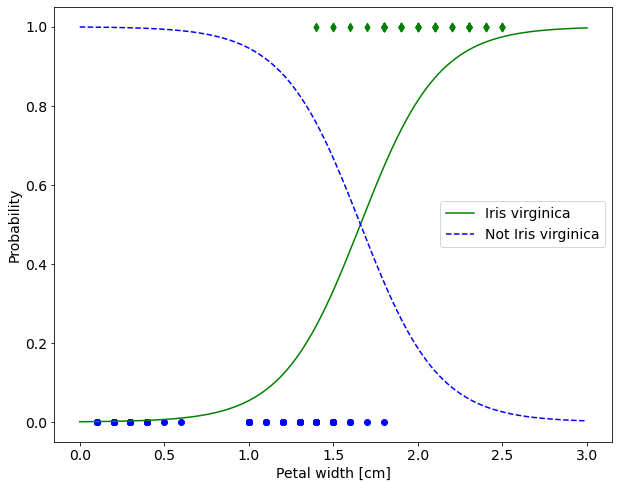

In [52]:
# Look at the probabilities it predicted based on petal width
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)
plt.plot(X_new, y_proba[:, 1], 'g-', label='Iris virginica') # predict_prob outputs a probability for each class, hence [:,1] here
plt.plot(X_new, y_proba[:, 0], 'b--', label='Not Iris virginica')
plt.legend()
plt.scatter(X[y==1].ravel(), y[y==1], marker='d', c='green')
plt.scatter(X[y==0].ravel(), y[y==0], marker='o', c='blue')
plt.xlabel('Petal width [cm]')
plt.ylabel('Probability');

Can see that the values are not cleanly separable: there is a region of values where they overlap. The actual decision boundary is at ~ 1.6cm - but the model just returns the class of whichever class has the larger probability.

In [53]:
log_reg.predict([[1.5], [1.7]])

array([0, 1], dtype=int8)

In [58]:
# Do the same, but for 2 features
X = iris['data'][:, 2:] # only select the petal legnth & width
y = (iris['target'] == 2).astype(np.int8) # only want Iris virginica as positive class, everythign else 0

In [59]:
log_reg_2d = LogisticRegression()
log_reg_2d.fit(X, y)

LogisticRegression()

In [83]:
# Look at the probabilities it predicted based on petal width & length
x1_new = np.linspace(0, 8, 1000)
x2_new = np.linspace(0, 3, 1000)

X_1, X_2 = np.meshgrid(x1_new, x2_new)  # builds two-dimensional grids from one-dimensional arrays
y_proba = log_reg_2d.predict_proba(np.c_[X_1.reshape(-1, 1), X_2.reshape(-1, 1)]) # need to reshape meshgrids into 2-column array for predictions...

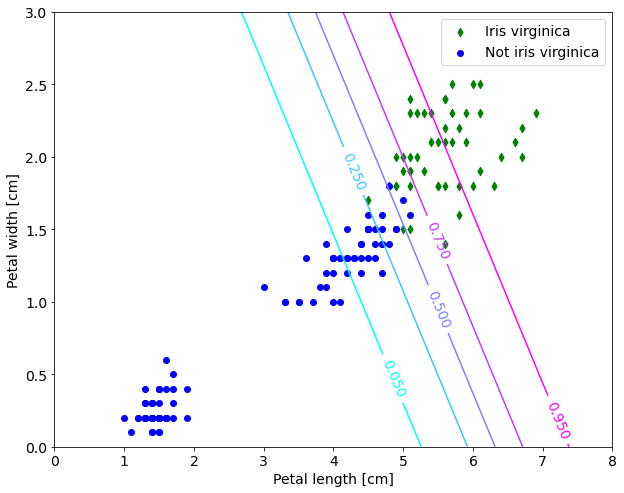

In [88]:
cnt = plt.contour(X_1, X_2, y_proba[:,1:].reshape(X_1.shape), # ...then we reshape back to match meshgrid for plt.contour
                  levels=[0.05, 0.25, 0.5, 0.75, 0.95], cmap='cool')
plt.clabel(cnt, inline=1)
plt.scatter(X[y==1, 0], X[y==1, 1], marker='d', c='green', label='Iris virginica')
plt.scatter(X[y==0, 0], X[y==0, 1], marker='o', c='blue', label='Not iris virginica')
plt.xlabel('Petal length [cm]')
plt.ylabel('Petal width [cm]');
plt.legend();

NB in sklearn, LogisticRegression already has ridge regression: instead of $\alpha$, it is controlled by $C = 1/\alpha$.

We can also find the decision boundary line:

\begin{equation}
\hat{p} = 0.5 = \frac{1}{1+\exp(-\hat{y})} \to \hat{y} = 0.
\end{equation}

Then we simply have to solve the linear regression for 2D case:
\begin{equation}
\vec{\theta}\cdot\vec{x}  = 0 \\
\to \\
x_2 = -\frac{\theta_1}{\theta_2} x_1 - \frac{b}{\theta_2}
\end{equation}

to get into the form $y=mx + c$

## Softmax regression - logistic regression for multiple classes

No need to multiple binary classifiers to generalise to multiple classes: can generalise to **softmax regression** or **multinomial logistic regression**.

For a given instance $\vec{x}$, compute score $s_k(\vec{x})$ for each class $k$, with its own set of parameters $\theta^{(k)}$:

\begin{equation}
s_k(\vec{x}) = \vec{\theta}^{(k)}\cdot \vec{x}
\end{equation}

N.B. $\theta$ can be stored in one parameter matrix, $\mathbf{\Theta}$, where each row corresponds to a class.

Once $s_k$ has been computed for a given instance $\vec{x}$, we can estimate the probability $\hat{p}$ that the instance belongs to class $k$ using the **softmax function**:

\begin{equation}
\hat{p}_k = \sigma(\vec{s}(\vec{x}))_k = \frac{\exp(s_k(\vec{x}))}{\sum_{j=1}^{K} \exp(s_j(\vec{x}))}
\end{equation}

i.e. calculate the exponential of every score, and normalising them. Scores called **logits** or **log-odds** (altho techincally unnormalised log-odds).

- Sum in denominator runs over all $K$ classes.

- $\vec{s}(\vec{x})$ is the vector of scores for each class, for a given instance $\vec{x}$.

- $\sigma(\vec{s}(\vec{x}))$ is the estimated probability that the instance $\vec{x}$ belongs to the class $k$, gen the scores of each class for that instance.

The classifier then predicts the class with the largest probability (so while it **is multiclass**, it is **not multioutput**).

### Cross-entropy cost function

Use **cross-entropy** as cost function:

\begin{equation}
J(\mathbf{\Theta}) = -\frac{1}{m}\sum_{i=1}^m \sum_{k=1}^K y_k^{(i)} \log(\hat{p}^{(i)}_k)
\end{equation}

where $y_k^{(i)}$ is the target probability that instance $i$ belongs to class $k$. Generally 1 or 0.

When $K=2$, same as logistic regression cost function.

Cross-entropy is the average number of bits you need to send information about something, given some prior assumptions you make about it.

i.e. how many bits does it take to transform your assumed distribution $q$ into the distribution $p$: 
\begin{equation}
H(p, q) = - \sum_x p(x) \log q(x) \text{ [discrete version]} = - \mathrm{E}_p[\log q(x)]
\end{equation}

where $\mathrm{E}_p[\log q(x)]$ is the expected value of $\log q(x)$ wrt p.

To make the "transformation cost" bit more clear, we can also rewrite $H(p, q)$ as entropy of $p$ ($H(p)$) plus some extra part: the **Kullback-Leibler Divergence**, $D_{KL}$:
\begin{equation}
H(p, q) = H(p) + D_{KL} (p||q) \\
D_{KL} (p||q) = \sum p \log \left( \frac{p}{q} \right)
\end{equation}

Note - **not symmetric for** $p \Leftrightarrow q$

**Cross-entropy is log-likelihood**: assume we have outcomes $i$ with probability $q_i$, while the frequency of the outcome is $p_i$ in the training set, with $N$ events total. Then the total likelihood is:
\begin{equation}
\mathcal{L} = \prod_i q_i^{Np_i} = \prod_i (\text{probability of outcome i})^{\text{number of times i occurs}}
\end{equation}

then the log-likelihood is
\begin{equation}
\log(\mathcal{L}) = \sum_i Np_i \log(q_i)
\end{equation}

and we can see that the averaged negative log-likelihood is just $H$:
\begin{equation}
-\frac{1}{N}\log(\mathcal{L}) = -\sum_i p_i \log(q_i) = H(p, q)
\end{equation}

The gradient of cross-entropy is:
\begin{equation}
\nabla_{\vec{\theta}} J(\mathbf{\Theta}) = \frac{1}{m} \sum_{i=1}^m \left( \hat{p}_k^{(i)} - y_k^{(i)} \right) \vec{x}^{(i)}
\end{equation}

which can then be used with GD

## Softmax on Iris

sklearn uses OvR in `LogisticRegression` by default; to use softmax, add `multi_class="multinomial"` to ctor, and specify a solver (`lbfgs`). It also uses $\ell_2$ regularisation by default, controlled by `C` parameter (inverse strength)

In [91]:
X = iris['data'][:, (2, 3)]  # petal length, width
y = iris['target']

In [92]:
softmax_reg = LogisticRegression(multi_class='multinomial', solver='lbfgs', C=10)
softmax_reg.fit(X,y)

LogisticRegression(C=10, multi_class='multinomial')

In [93]:
softmax_reg.predict([[5, 2]])

array([2])

In [94]:
softmax_reg.classes_

array([0, 1, 2])

In [95]:
softmax_reg.predict_proba([[5, 2]])

array([[6.38014896e-07, 5.74929995e-02, 9.42506362e-01]])

In [104]:
# Look at the probabilities it predicted based on petal width & length
x1_new = np.linspace(0, 8, 1000)
x2_new = np.linspace(0, 3, 1000)

X_1, X_2 = np.meshgrid(x1_new, x2_new)  # builds two-dimensional grids from one-dimensional arrays
y_proba = softmax_reg.predict_proba(np.c_[X_1.reshape(-1, 1), X_2.reshape(-1, 1)]) # need to reshape meshgrids into 2-column array for predictions...
y_predict = softmax_reg.predict(np.c_[X_1.reshape(-1, 1), X_2.reshape(-1, 1)]) # need to reshape meshgrids into 2-column array for predictions...

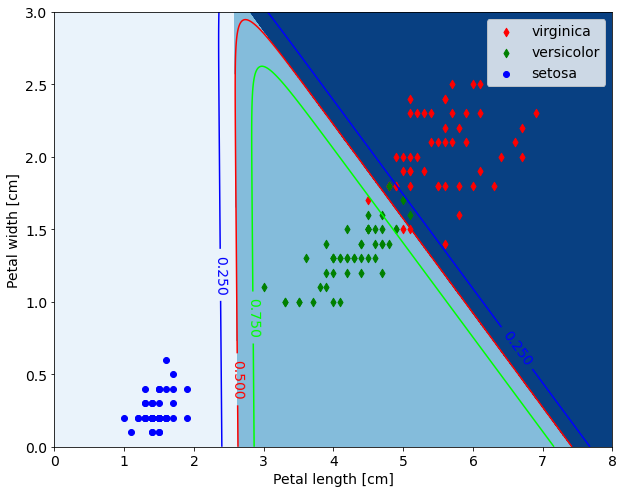

In [115]:
plt.contourf(X_1, X_2, y_predict.reshape(X_1.shape), cmap='Blues')
cnt = plt.contour(X_1, X_2, y_proba[:,1:2].reshape(X_1.shape), # ...then we reshape back to match meshgrid for plt.contour
                  levels=[0.25, 0.5, 0.75], cmap='brg')
plt.clabel(cnt, inline=1)
plt.scatter(X[y==2, 0], X[y==2, 1], marker='d', c='red', label=iris['target_names'][2])
plt.scatter(X[y==1, 0], X[y==1, 1], marker='d', c='green', label=iris['target_names'][1])
plt.scatter(X[y==0, 0], X[y==0, 1], marker='o', c='blue', label=iris['target_names'][0])
plt.xlabel('Petal length [cm]')
plt.ylabel('Petal width [cm]');
plt.legend();

We can now see the decision boundary & probability line between classes.

**Decision boundaries between classes is linear**.

# Exercises

### 1. Which LR training algo if you have millions of features?

Stochastic or Mini-batch gradient descent. Not SVD or normal equation - too large for memory.

### 2. Features have different scales - which algos might suffer? How to fix this?

Gradient descent will look like a long bowl, and will take a while to converge to minimum. Regularisation methods also assume similar scales among features.

Use StandardScaler to scale prior to fitting.

Normal equation & SVD don't care about scales.

### 3. Can GD get stuck in minimum with Logistic regression model?

No, it's a convex cost function

### 4. Do all GD algos converge to the same result (if left long enough)?

In theory, all should head towards the same minimum provided learning rate not too high, and cost function convex.
Not necessarily - stochastic GD will keep flitting about. Need to reduce learning rate as it converges towards a solution.

### 5. Use batch GD, but validation error increases with every epoch - why? How to fix?

If training error _not_ increasing, then model is overfitting to training data and not generalising well. (or you screwed up training & validation datasets so that the latter isn't similar to the former)

If training model also increasing, then learning rate too high - starting to diverge.

### 6. Should you stop mini-batch GD once validation error goes up?

Not necessarily - somewhat stochastic, so require it to go up consistently for N > 1 iterations, then stop it.

### 7. Which GD algo reaches near optimum solution fastest? Which converges?

Mini-batch and stochastic GD will reach it first as only need a few instances, not whole dataset. But harder to converge due to stochastic nature. Solve by reducing learning rate with # steps.

### 8. Using polynomial regression - but large diff between training error & validation error. Why? How to solve?

Probably overfitting to training set, not generalising to validation set.

Solve by:

- reducing model complexity (reduce degree)
- regularise with ridge/lasso
- increase training dataset size

### 9. Using ridge regression - training error ~ validation err, but both high. Is this high bias or high variance? Increase $\alpha$ or reduce it?

High bias - probably underfitting. Reduce $\alpha$ to reduce regularisation effect, allow more complexity.

### 10. Why would you use ridge regression vs linear? Lasso vs ridge? Elastic net vs lasso?

Ridge vs linear:

- to ensure model doesn't overfit, performs better

Lasso vs ridge:

- Lasso can remove redundant parameters - gives sparse model

Elastic net vs lasso:

- Elastic net behaves better if # features > # samples, or correlated features

### 11. Classify pictures as outdoor/indoor and day/night. Use 2 Logisitic regressions? Or one softmax classifier?

Use 2 Logisitic regressions, since not exclusive classes, i.e. totally separate things to classify. Softmax only good for multiclass classifier, for mutually exclusive classes.

### 12. Do batch GD with early stopping for Softmax without sklearn

In [118]:
X = iris['data'][:, (2, 3)]  # petal length, width
y = iris['target']

In [121]:
np.bincount(y)

array([50, 50, 50])

In [273]:
np.random.seed(2042)

In [179]:
# Add a bias term
X_with_bias = np.c_[np.ones([len(X), 1]), X]

We need training & validation sets in order to do early stopping.

In [274]:
def my_test_train_split(X, y, test_factor):
    # TODO we should make sure we split per class, to avoid ruining fractions?
    N = len(X)
    N_training = int(N * (1-test_factor))
    rand_ind = np.random.permutation(N)
    X_shuffled = X[rand_ind,:]
    y_shuffled = y[rand_ind]
    X_train = X_shuffled[:N_training, :]
    X_test = X_shuffled[N_training:, :]
    y_train = y_shuffled[:N_training]
    y_test = y_shuffled[N_training:]
    return X_train, X_test, y_train, y_test

In [322]:
X_train, X_test, y_train, y_test = my_test_train_split(X_with_bias, y, 0.2)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(120, 3) (30, 3) (120,) (30,)


We also need to convert our class categories into one-hot encoding, so we can have a probability per class:

In [323]:
def convert_to_one_hot(y):
    unique_vals = np.unique(y)
    result = np.zeros((len(y), len(unique_vals)))
    result[np.arange(len(y)), y] = 1  # why arange needed? why doesnt : work?
    return result

In [324]:
y_train_one_hot = convert_to_one_hot(y_train)
y_test_one_hot = convert_to_one_hot(y_test)

In [325]:
y_train_one_hot[:10]

array([[1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]])

In [326]:
def softmax(scores):
    exp_scores = np.exp(scores)
    return exp_scores / exp_scores.sum(axis=1, keepdims=True) # keep dims to keep shape to divide properly

In [371]:
# batch GD
eta = 0.1  # learning rate
n_iterations = 100000

n_features = X_train.shape[1]
n_classes = y_train_one_hot.shape[1]
n_samples = X_train.shape[0]
print('n_features', n_features, 'n_classes', n_classes, 'n_samples', n_samples)
print(X_train.shape)
theta = np.random.randn(n_features, n_classes) # include bias term
print('theta', theta.shape)
print('starting theta', theta)

# regularisation strength
alpha = 0.1

# for early stopping
best_theta = theta
best_score = np.inf
best_epoch = -1

for iteration in range(n_iterations):
    # calc score
    scores = X_train @ theta # scores is a n_samples x n_classes matrix
    y_proba = softmax(scores) # yproba is a n_samples x n_classes matrix
    
    # cross entropy cost function
    cross_entropy = -np.mean(np.sum(y_train_one_hot * np.log(y_proba + 1E-7), axis=1)) # axis=1 to sum over classes, mean will sum over rows. add 1E-7 to avoid log(0)
    l2_loss = 0.5 * np.sum(np.square(theta[1:]))
    
    j = cross_entropy + alpha*l2_loss
    
    # calc gradient, also include regularisation term (that excludes bias, 1st row)
    gradients = ((X_train.T @ (y_proba - y_train_one_hot)) / n_samples) +  np.r_[np.zeros([1, n_classes]), alpha * theta[1:]]
#     print(gradients.shape)

    # update theta
    theta = theta - eta * gradients

    if j < best_score:
        best_score = j
        best_theta = np.copy(theta)
        best_epoch = iteration
    else:
        print('stopping at', iteration)
        break
#     print(iteration, theta, j)

print('best theta', best_theta)
print('best epoch', best_epoch)
print('best score', best_score)

n_features 3 n_classes 3 n_samples 120
(120, 3)
theta (3, 3)
starting theta [[ 0.46624682 -1.32861607 -0.61815701]
 [ 0.43324777 -0.71465491 -0.50059806]
 [-0.3425436   0.89463347  1.49876834]]
stopping at 16408
best theta [[ 3.74411703 -0.03487873 -5.18976456]
 [-1.09121336  0.11892999  0.97228337]
 [-0.43857015 -0.13446195  0.5730321 ]]
best epoch 16407
best score 0.5027738389207119


We can test our model on the test set:

In [372]:
scores = X_test @ best_theta
y_test_proba = softmax(scores)
y_predict = np.argmax(y_test_proba, axis=1) # convert probabilities into predictions

In [373]:
accuracy_score = np.mean(y_predict == y_test)
accuracy_score

1.0

Impressive accuracy! Probably from being so small?

Plot decision boundaries:

In [374]:
x1_new = np.linspace(0, 8, 1000)
x2_new = np.linspace(0, 3, 1000)

X_1, X_2 = np.meshgrid(x1_new, x2_new)  # builds two-dimensional grids from one-dimensional arrays
X_1_flat = X_1.ravel()
X_2_flat = X_2.ravel()
X_contour = np.c_[np.ones_like(X_1_flat), X_1_flat, X_2_flat] # add bias term, convert to format we expect of (m * n)

In [375]:
logits = X_contour @ best_theta
y_proba = softmax(logits)
y_predicts = np.argmax(y_proba, axis=1)

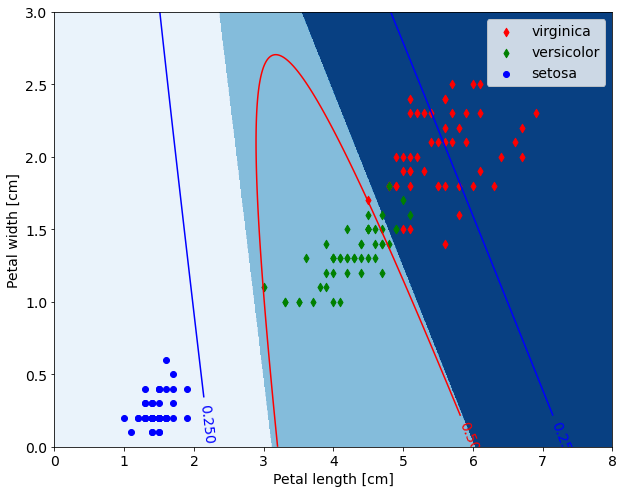

In [376]:
plt.contourf(X_1, X_2, y_predicts.reshape(X_1.shape), cmap='Blues')
cnt = plt.contour(X_1, X_2, y_proba[:,1].reshape(X_1.shape), # ...then we reshape back to match meshgrid for plt.contour
                  levels=[0.25, 0.5, 0.75], cmap='brg')
plt.clabel(cnt, inline=1)
plt.scatter(X[y==2, 0], X[y==2, 1], marker='d', c='red', label=iris['target_names'][2])
plt.scatter(X[y==1, 0], X[y==1, 1], marker='d', c='green', label=iris['target_names'][1])
plt.scatter(X[y==0, 0], X[y==0, 1], marker='o', c='blue', label=iris['target_names'][0])
plt.xlabel('Petal length [cm]')
plt.ylabel('Petal width [cm]');
plt.legend();

Yay it looks reasonable!